## Models

We chose to use Naive Bayes, Decision Tree, and K Nearest Neighbors classifiers to predict our data.

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def nb_model(x_train, x_test, y_train, y_test, var_smoothing=1e-9):
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = model.score(x_test, y_test)
    return y_pred, score

def tree_model(x_train, x_test, y_train, y_test, max_depth=None, criterion='gini'):
    model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = model.score(x_test, y_test)
    return y_pred, score


def knn_model(x_train, x_test, y_train, y_test, weights='uniform', leaf_size=30, p=2):
    model = KNeighborsClassifier(weights=weights, leaf_size=leaf_size, p=p)
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = model.score(x_test, y_test)
    return y_pred, score



Data is split for training and testing.

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/cupid_scientists_pp.csv')
target = 'match'
desc_features = list(data.columns)
desc_features.remove(target)

x = data[desc_features]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

## Optimization

### Hyperparameter Optimization (Grid Search with Accuracy Score)

Log loss parameter was introdiced in scikit-learn version 1.1.2. If you encounter problems, please make sure your scikit-learn package is up to date before running this code. `pip install scikit-learn==1.1.3`

In [17]:
def optimize_tree():
    depths = []
    crits = []
    scores = []
    for depth in [i for i in range(1,15)]:
        for crit in ['gini', 'entropy', 'log_loss']:
            _, score = tree_model(x_train, x_test, y_train, y_test, max_depth=depth, criterion=crit)
            scores.append(score)
            depths.append(depth)
            crits.append(crit)
    best = scores.index(max(scores))
    print(f'Maximum score {scores[best]} at depth {depths[best]} using {crits[best]}')
    return {
        'max_depth': depths[best],
        'criterion': crits[best]
    }

tree_params = optimize_tree()

Maximum score 0.8466698610445615 at depth 14 using entropy


In [18]:
def optimize_knn():
    weights = []
    leaf_sizes = []
    ps = []
    scores = []
    for weight in ['uniform', 'distance']:
        for p in [1,2,3,4]:
            for leaf_size in [10, 30, 50, 100]:
                _, score = knn_model(x_train, x_test, y_train, y_test, weights=weight, leaf_size=leaf_size, p=p)
                scores.append(score)
                weights.append(weight)
                leaf_sizes.append(leaf_size)
                ps.append(p)
    best = scores.index(max(scores))
    print(f'Maximum score {scores[best]} with weights {weights[best]}, leaf size {leaf_sizes[best]} and p={ps[best]}')
    return {
        'weights': weights[best],
        'leaf_size': leaf_sizes[best],
        'p': ps[best]
    }

knn_params = optimize_knn()

Maximum score 0.8667944417824629 with weights distance, leaf size 10 and p=1


In [19]:
def optimize_nb():
    smooths = []
    scores = []
    for smoothing in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]:
        _, score = nb_model(x_train, x_test, y_train, y_test, var_smoothing=smoothing)
        smooths.append(smoothing)
        scores.append(score)
    best = scores.index(max(scores))
    print(f'Maximum score {scores[best]} with smoothing {smooths[best]}')
    return {
        'var_smoothing': smooths[best]
    }

nb_params = optimize_nb()

Maximum score 0.8279827503593675 with smoothing 0.1


## Evaluation

Based on accuracy alone, the decision tree model seems capable of the best results. However, we wanted to dive deeper.

In [20]:
def binary_conf_matrix(observation, p_scores, threshold):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(observation)):
        prediction = (1 if p_scores[i] >= threshold else 0)
        tf = (True if prediction == observation[i] else False)
        pn = (True if prediction == 1 else False)
        if tf and pn:
            TP += 1
        if tf and not pn:
            TN += 1
        if not tf and pn:
            FP += 1
        if not tf and not pn:
            FN += 1

    out = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }
    return out

In [21]:
# percent of correct predictions
def accuracy(observation, p_scores, threshold):
    # (TP + TN) / (TP + TN + FP + FN)
    scores = binary_conf_matrix(observation, p_scores, threshold)
    out = scores['TP'] + scores['TN']
    out /= (scores['TP'] + scores['TN'] + scores['FP'] + scores['FN'])
    return out

# percent of predicted positives that were correct
def precision(observation, p_scores, threshold):
    # TP / (TP + FP)
    scores = binary_conf_matrix(observation, p_scores, threshold)
    out = scores['TP']
    out /= (scores['TP'] + scores['FP'])
    return out

# percent of real positives correctly predicted
def recall(observation, p_scores, threshold):
    # TP / (TP + FN)
    scores = binary_conf_matrix(observation, p_scores, threshold)
    out = scores['TP']
    out /= (scores['TP'] + scores['FN'])
    return out

# f1 score
def f1score(observation, p_scores, threshold):
    # 2(precision * recall) / (precision + recall)
    prec = precision(observation, p_scores, threshold)
    rec = recall(observation, p_scores, threshold)
    out = 2 * (prec * rec)
    out /= (prec + rec)
    return out

In [39]:
# Hanssen-Kuipers Skill Score: How well the model separates matches from non-matches
def tss(observation, p_scores, threshold):
    # (TP / (TP + FN)) - (FP / (FP + TN))
    scores = binary_conf_matrix(observation, p_scores, threshold)
    first = scores['TP']
    first /= (scores['TP'] + scores['FN'])
    second = scores['FP']
    second /= (scores['FP'] + scores['TN'])
    out = first - second
    return out

# Gilbert Skill Score: How well predicted matches correspond to true matches, accounting for lucky random predictions
def gss(observation, p_scores, threshold):
    # random hits = ((TP + FN) * (TP + FP)) / (TP + FP + TN + FN)
    # gss = (TP - random) / (TP + FN + FP - random)
    scores = binary_conf_matrix(observation, p_scores, threshold)
    hits_random = scores['TP'] + scores['FN']
    hits_random *= (scores['TP'] + scores['FP'])
    hits_random /= (scores['TP'] + scores['FP'] + scores['TN'] + scores['FN'])
    out = scores['TP'] - hits_random
    out /= (scores['TP'] + scores['FN'] + scores['FP'] - hits_random)
    return out

As another element of hyperparameter optimization, we can pick the best threshold for prediction to apply with our model.

In [23]:
# Pick best threshold based on a specific metric
def pick_threshold(observation, p_scores, mfunc):
    performances = []
    for threshold in [i/100 for i in range(0,101)]:
        try:
            perf = mfunc(observation, p_scores, threshold)
        except ZeroDivisionError: # encountered with FAR score
            perf = -1
        performances.append(perf)
    best_index = performances.index(max(performances))
    best_threshold = best_index / 100
    return best_threshold

def pick_threshold_all_metrics(observation, p_scores, mfuncs=[accuracy, f1score, tss, gss]):
    # precision and recall not included because they will automatically bias towards thresholds of 0 and 1
    thresholds = []
    for mfunc in mfuncs:
        threshold = pick_threshold(observation, p_scores, mfunc)
        thresholds.append(threshold)
    return thresholds

In [24]:
def get_metrics(observation, p_scores, threshold):
    metrics = {
        'accuracy': accuracy(observation, p_scores, threshold),
        'precision': precision(observation, p_scores, threshold),
        'recall': recall(observation, p_scores, threshold),
        'f1score': f1score(observation, p_scores, threshold),
        'tss': tss(observation, p_scores, threshold),
        'gss': gss(observation, p_scores, threshold),
    }
    return metrics

Before even looking at the further metrics, we see that when given a threshold of 0.5, the Naive Bayes classifier is actually just getting its decent accuracy score by picking a negative match 100% of the time. This is definitely not what we want!

However, even when selecting an optimum low threshold, our accuracy is around 63%. This is a poor accuracy compred to the other models below, and our other metrics are also much lower than the models that follow.

In [45]:
p_scores, score = nb_model(x_train, x_test, y_train, y_test, **nb_params)
# print(pick_threshold_all_metrics(y_test, p_scores))

print('Before selecting optimum threshold:')
print(binary_conf_matrix(list(y_test), p_scores, 0.5))

print('\nSelecting optimum threshold:')
thresholds = pick_threshold_all_metrics(list(y_test), p_scores)
print(thresholds)

avg_best_thresh = (thresholds[1] + thresholds[2] + thresholds[3]) / 3
print(f'Selected best threshold based on F1 Score, TSS, and GSS: {avg_best_thresh}')

nb_matrix = binary_conf_matrix(list(y_test), p_scores, avg_best_thresh)
print(nb_matrix)

nb_metrics = get_metrics(list(y_test), p_scores, avg_best_thresh)
print(nb_metrics)

Before selecting optimum threshold:
{'TP': 0, 'TN': 1728, 'FP': 0, 'FN': 359}

Selecting optimum threshold:
[0.44, 0.16, 0.21, 0.23]
Selected best threshold based on F1 Score, TSS, and GSS: 0.19999999999999998
{'TP': 166, 'TN': 1150, 'FP': 578, 'FN': 193}
{'accuracy': 0.6305701964542405, 'precision': 0.22311827956989247, 'recall': 0.4623955431754875, 'f1score': 0.3009972801450589, 'tss': 0.12790480243474672, 'gss': 0.04699414779353278}


The decision tree's scores look much better and much more robust.

Asking for the best threshold per metric usually returns `[0.67, 0.29, 0.12, 0.41]` (sometimes these numbers are slightly different, depending on the parameters selected above, but the last 3 generally average around 0.28 altogether). The high first number is when tested with accuracy; because this dataset has far more failed matches than successful ones, so pure accuracy would be biased towards the negative result (high threshold). However, the other three favor a lower threshold, so that's what we consider for the threshold for the following metrics.

With this, we retain good accuracy (around 0.80) while having high other metrics. Additionally, we are more biased towards positive matches, which is a good thing -- we would prefer to have a possible match to show a user than not have anything to show at all when someone uses this app.

In [47]:
p_scores, score = tree_model(x_train, x_test, y_train, y_test, **tree_params)

thresholds = pick_threshold_all_metrics(list(y_test), p_scores)
print(thresholds)

avg_best_thresh = (thresholds[1] + thresholds[2] + thresholds[3]) / 3
print(f'Selected best threshold based on F1 Score, TSS, and GSS: {avg_best_thresh}')

tree_matrix = binary_conf_matrix(list(y_test), p_scores, avg_best_thresh)
print(tree_matrix)

tree_metrics = get_metrics(list(y_test), p_scores, avg_best_thresh)
print(tree_metrics)

[0.61, 0.29, 0.12, 0.41]
Selected best threshold based on F1 Score, TSS, and GSS: 0.2733333333333333
{'TP': 164, 'TN': 1487, 'FP': 241, 'FN': 195}
{'accuracy': 0.7910876856732152, 'precision': 0.4049382716049383, 'recall': 0.4568245125348189, 'f1score': 0.4293193717277487, 'tss': 0.31735691994222637, 'gss': 0.17787505477477963}


The K Neighbors model has similarly robust results, but with even higher metrics. With an optimum threshold of about 0.35 and an accuracy around 0.85, this is the model we recommend to our client for this app.

In [48]:
p_scores, score = knn_model(x_train, x_test, y_train, y_test, **knn_params)

thresholds = pick_threshold_all_metrics(list(y_test), p_scores)
print(thresholds)

avg_best_thresh = (thresholds[1] + thresholds[2] + thresholds[3]) / 3
print(f'Selected best threshold based on F1 Score, TSS, and GSS: {avg_best_thresh}')

knn_matrix = binary_conf_matrix(list(y_test), p_scores, avg_best_thresh)
print(knn_matrix)

knn_metrics = get_metrics(list(y_test), p_scores, avg_best_thresh)
print(knn_metrics)

[0.42, 0.42, 0.21, 0.42]
Selected best threshold based on F1 Score, TSS, and GSS: 0.35000000000000003
{'TP': 232, 'TN': 1534, 'FP': 194, 'FN': 127}
{'accuracy': 0.8461907043603258, 'precision': 0.5446009389671361, 'recall': 0.6462395543175488, 'f1score': 0.5910828025477708, 'tss': 0.5339710357990303, 'gss': 0.3308605771007524}


## Graphing results

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

def view_matrix(matrix, model):
    d = {
        'Actual Positive': [matrix['TP'], matrix['FN']],
        'Actual Negative': [matrix['FP'], matrix['TN']]
    }
    ind = ['Predicted Positive', 'Predicted Negative']
    df = pd.DataFrame(d, index=ind)
    print(model)
    display(df)

def graph_difference(all_scores, metric):
    color = '#d30b91'
    title = (metric[0].upper() + metric[1:] if metric not in ['tss', 'gss'] else metric.upper())
    labels = ['Naive Bayes', 'Decision Tree', 'K Nearest Neighbors']
    scores = [round(i[metric],2) for i in all_scores]
    data = {
        labels[i]: [scores[i]] for i in range(len(labels))
    }
    df = pd.DataFrame(data, index=[title])
    plt.title(title)
    plt.ylim(0,1)
    ax = sns.barplot(data=df, color=color)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.savefig(f'figs/eval/{metric}')
    plt.show()
    plt.close()

In [116]:
for matrix, model in zip([nb_matrix, tree_matrix, knn_matrix],['Naive Bayes', 'Decision Tree', 'K Nearest Neighbors']):
    view_matrix(matrix, model)

Naive Bayes


,Actual Positive,Actual Negative
Predicted Positive,166,578
Predicted Negative,193,1150


Decision Tree


,Actual Positive,Actual Negative
Predicted Positive,164,241
Predicted Negative,195,1487


K Nearest Neighbors


,Actual Positive,Actual Negative
Predicted Positive,232,194
Predicted Negative,127,1534


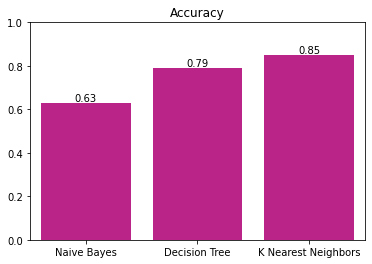

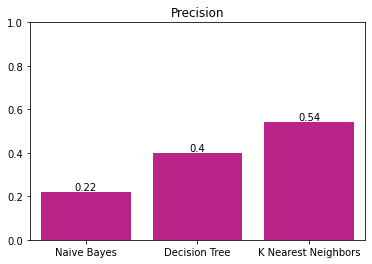

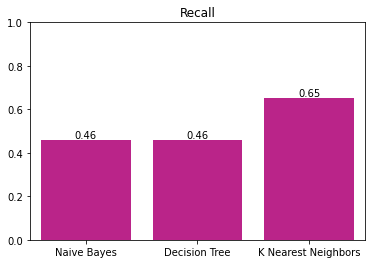

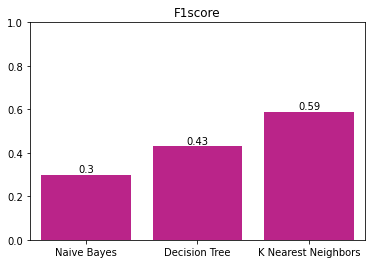

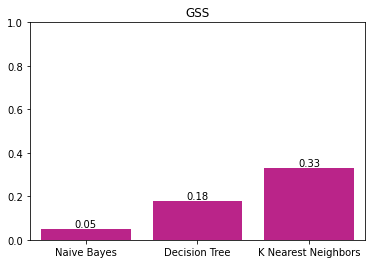

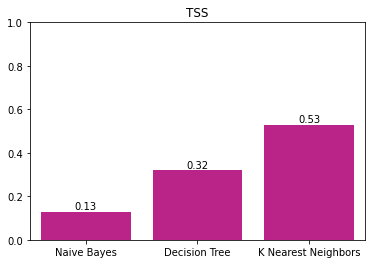

In [75]:
for metric in ['accuracy', 'precision', 'recall', 'f1score', 'gss', 'tss']:
    graph_difference([nb_metrics, tree_metrics, knn_metrics], metric)